# Catchphrase analysis

Sources:
- stopwords: https://www.ranks.nl/stopwords
- plotting function: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

In [55]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [160]:
stopwords_df = pd.read_csv('Datasets/scraped/stopwords.csv')
script_df = pd.read_csv('Datasets/data-society-the-simpsons-by-the-data/simpsons_script_lines.csv')
characters_df = pd.read_csv('Datasets/data-society-the-simpsons-by-the-data/simpsons_characters.csv')
episodes_df = pd.read_csv('Datasets/data-society-the-simpsons-by-the-data/simpsons_episodes.csv')
script_df['character_id'] = script_df['character_id'].fillna(0).astype(int)

C:\Users\nikol\AppData\Local\Temp\ipykernel_35272\3667293418.py:2: DtypeWarning: Columns (4,5,26) have mixed types. Specify dtype option on import or set low_memory=False.
  script_df = pd.read_csv('Datasets/data-society-the-simpsons-by-the-data/simpsons_script_lines.csv')


In [161]:
names_list = characters_df['normalized_name'].tolist()
sep_names_list = []
for name in names_list:
    if ' ' in name:
        sep_names_list += name.split(' ')
    else:
        sep_names_list.append(name)
stopwords_df = pd.concat([stopwords_df, pd.DataFrame({'stopwords':sep_names_list})], ignore_index=True)

In [162]:
character_lines = []
for i in range(6000):
    spaced_lines = script_df.loc[script_df['character_id']==(i+1)]['normalized_text']+' '
    sep_lines = spaced_lines.tolist()
    sep_lines = [x for x in sep_lines if str(x) != 'nan']
    total_lines = ''.join(sep_lines)
    character_lines.append(total_lines)

In [59]:
vectorizer = TfidfVectorizer(stop_words=stopwords_df['stopwords'].tolist(),
                             lowercase=True, max_df=0.005, norm='l2', smooth_idf=True)
tf_idf_matrix = vectorizer.fit_transform(character_lines)
feature_names = vectorizer.get_feature_names_out()

D:\Documents\Programming\datamadness\venv\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['11', '13', '16', '20', '24', '32', '3po', '40', '52s', '60', '80', '800', 'abdul', 'alikes', 'altered', 'amer', 'anti', 'apocalyptic', 'armed', 'ass', 'auto', 'autograph', 'bare', 'beaver', 'bitten', 'bohemian', 'bot', 'bottle', 'bound', 'brew', 'busted', 'cart', 'chapin', 'check', 'chested', 'chilled', 'clam', 'clams', 'clean', 'clone', 'conrad', 'crest', 'day', 'deranged', 'dia', 'ding', 'dong', 'drive', 'dubbed', 'electronically', 'elegantly', 'er', 'ers', 'espn', 'esque', 'euro', 'european', 'eyed', 'fast', 'faucet', 'fedex', 'fielder', 'foot', 'ghibli', 'glue', 'goer', 'golly', 'good', 'goony', 'grade', 'green', 'grumpy', 'guilden', 'hag', 'haired', 'hairy', 'handed', 'hard', 'hating', 'headed', 'holo', 'hop', 'ish', 'jabbar', 'jail', 'jam', 'jocks', 'jub', 'kicked'

In [60]:
def top_k_words(id):
    feature_scores = tf_idf_matrix[id].toarray().tolist()[0]
    feature_dict = dict(zip(feature_names, feature_scores))
    top_k_features = sorted(feature_dict.items(), key=lambda x: x[1], reverse=True)[:10]

    top_k_keywords = [feature[0] for feature in top_k_features]
    print(characters_df.loc[characters_df['id']==id+1]['name'])
    print(top_k_keywords)

top_k_words(7)

71    Bart Simpson
Name: name, dtype: object
['carumba', 'ay', 'awesome', 'lame', 'sucks', 'nyah', 'homework', 'aye', 'prank', 'crappy']


In [474]:
def find_character(partial_name):
    for char_id in range(6000):
        if char_id+1 in characters_df['id'].tolist():
            n = characters_df.loc[characters_df['id']==char_id+1]['name'].iloc[0]
            if partial_name in n.lower():
                return char_id, n.lower()

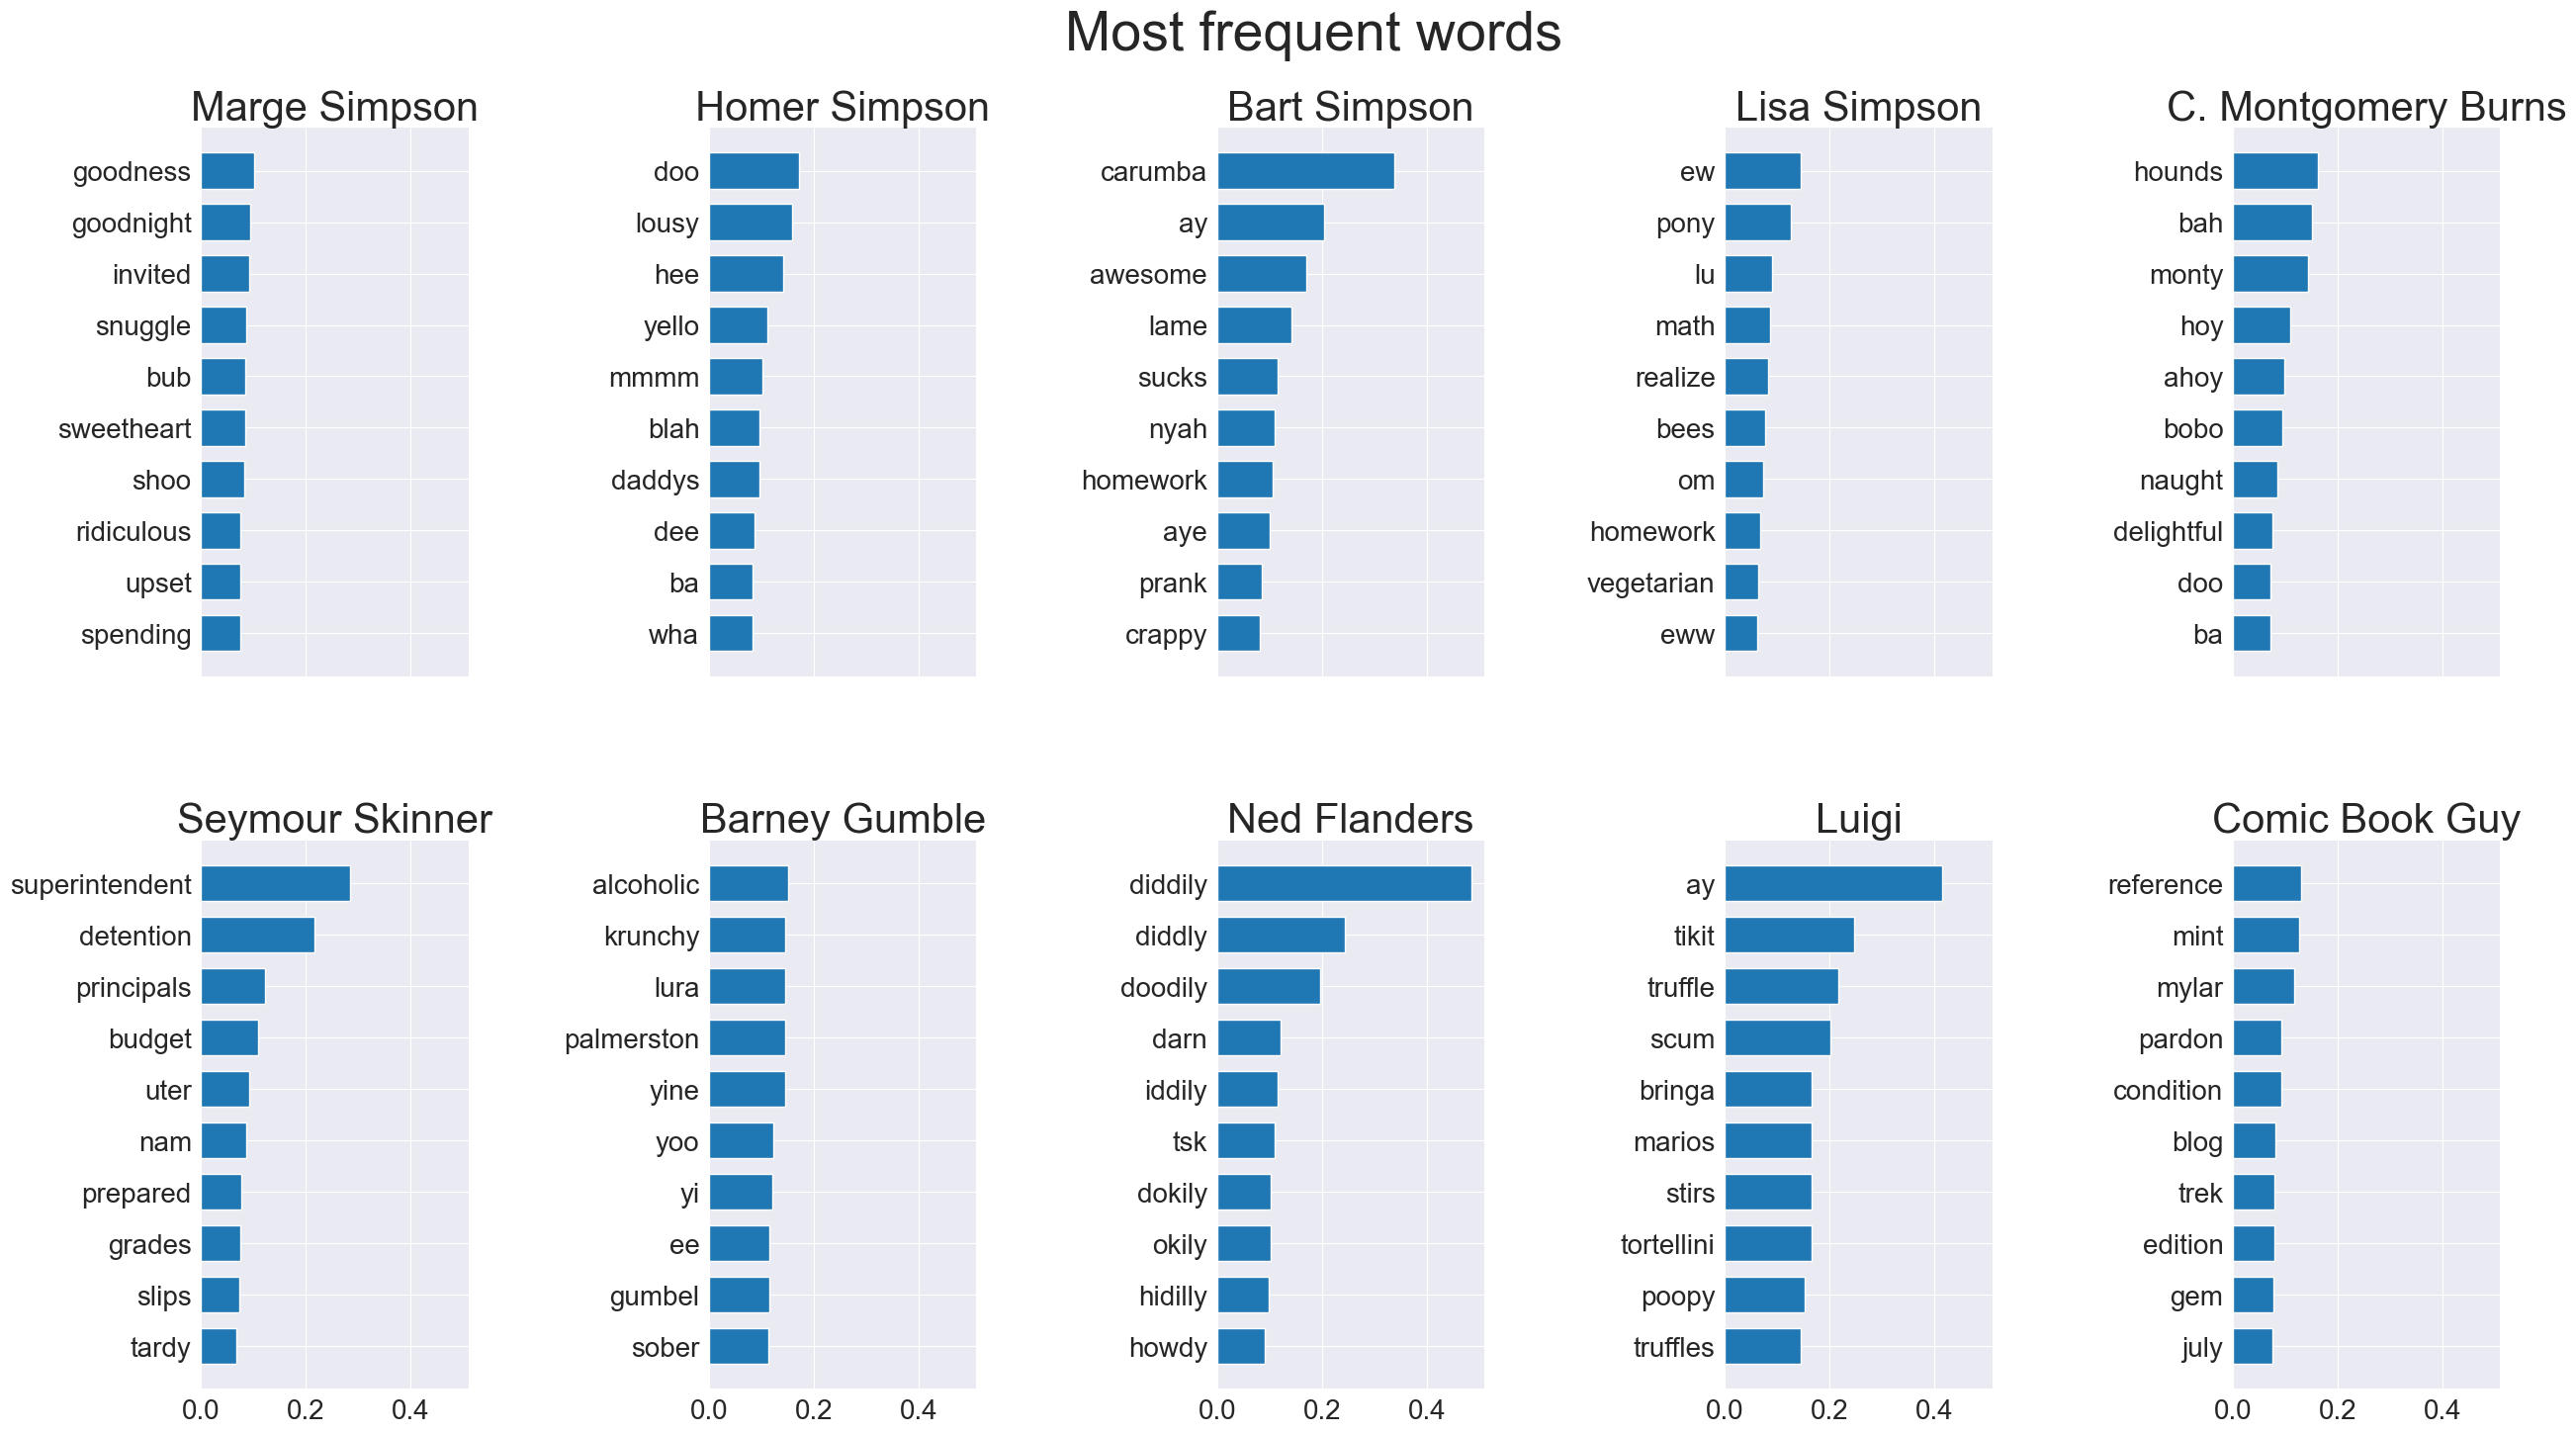

In [118]:
selected_characters = [0, 1, 7, 8, 14, 2, 17, 10, 1434, 800]
catchprases = []
def plot_top_words():
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for idx, char_id in enumerate(selected_characters):
        feature_scores = tf_idf_matrix[char_id].toarray().tolist()[0]
        feature_dict = dict(zip(feature_names, feature_scores))
        top_k_features = sorted(feature_dict.items(), key=lambda x: x[1], reverse=True)[:10]
        top_k_keywords = [feature[0] for feature in top_k_features]

        catchprases.append(top_k_keywords[0])

        weights = [feature[1] for feature in top_k_features]

        character_name = characters_df.loc[characters_df['id']==char_id+1]['name'].iloc[0]

        ax = axes[idx]
        ax.barh(top_k_keywords, weights, height=0.7)
        ax.set_title(f"{character_name}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle('Most frequent words', fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
plot_top_words()

In [130]:
def smooth(scalars, weight):
    last = scalars[0]
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val

    return smoothed

In [182]:
script_sorted = script_df.sort_values(by='episode_id')

temp_df = episodes_df[['number_in_series', 'season']].sort_values(by='number_in_series')
temp_df = temp_df.rename(columns={'number_in_series':'episode_id'})

#script_sorted = pd.concat([script_sorted, temp_df],axis=1)
script_sorted = pd.merge(script_sorted, temp_df, on='episode_id')
script_sorted.head(10)

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,...,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,season
0,147,1,146,Homer Simpson: (GRABBING IT) Gimme that!,642000,TRUE,2,14.0,Homer Simpson,Circus of Values,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,248,1,247,Clerk: Less costume purchase --,940000,TRUE,28,19.0,Clerk,PERSONNEL OFFICE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,247,1,246,Homer Simpson: Santa?,940000,TRUE,2,19.0,Homer Simpson,PERSONNEL OFFICE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,246,1,245,Clerk: Less Santa training --,940000,TRUE,28,19.0,Clerk,PERSONNEL OFFICE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,245,1,244,Homer Simpson: But...,940000,TRUE,2,19.0,Homer Simpson,PERSONNEL OFFICE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
5,244,1,243,Clerk: Less unemployment insurance --,940000,TRUE,28,19.0,Clerk,PERSONNEL OFFICE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
6,243,1,242,Homer Simpson: Yeah.,940000,TRUE,2,19.0,Homer Simpson,PERSONNEL OFFICE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7,242,1,241,Clerk: That's right. One hundred and twenty do...,936000,TRUE,28,19.0,Clerk,PERSONNEL OFFICE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
8,241,1,240,"Homer Simpson: Come on, son. Let's go cash thi...",930000,TRUE,2,19.0,Homer Simpson,PERSONNEL OFFICE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
9,240,1,239,"Clerk: Simpson, Homer? Here you go.",928000,TRUE,28,19.0,Clerk,PERSONNEL OFFICE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [180]:
script_sorted

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,...,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
148909,147,1,146,Homer Simpson: (GRABBING IT) Gimme that!,642000,TRUE,2,14.0,Homer Simpson,Circus of Values,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149011,248,1,247,Clerk: Less costume purchase --,940000,TRUE,28,19.0,Clerk,PERSONNEL OFFICE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149010,247,1,246,Homer Simpson: Santa?,940000,TRUE,2,19.0,Homer Simpson,PERSONNEL OFFICE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149009,246,1,245,Clerk: Less Santa training --,940000,TRUE,28,19.0,Clerk,PERSONNEL OFFICE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
149008,245,1,244,Homer Simpson: But...,940000,TRUE,2,19.0,Homer Simpson,PERSONNEL OFFICE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147658,158183,568,73,Apu Nahasapeemapetilon: You all sit at differe...,568000,TRUE,208,4454.0,Apu Nahasapeemapetilon,RIVERBOAT CASINO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147659,158184,568,74,Apu Nahasapeemapetilon: Ignore all distractions!,577000,TRUE,208,4454.0,Apu Nahasapeemapetilon,RIVERBOAT CASINO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147660,158185,568,75,Apu Nahasapeemapetilon: When the count is high...,585000,TRUE,208,4454.0,Apu Nahasapeemapetilon,RIVERBOAT CASINO,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147649,158174,568,64,"Rev. Timothy Lovejoy: (TO MARGE, SIGHS) Homer ...",503000,TRUE,140,136.0,Rev. Timothy Lovejoy,Kwik-E-Mart,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [173]:
#
temp_df = episodes_df[['number_in_series', 'season']].sort_values(by='number_in_series')
temp_df = temp_df.rename(columns={'number_in_series':'episode_id'})
temp_df

,episodes_id,season
241,1,1
242,2,1
550,3,1
243,4,1
525,5,1
...,...,...
575,596,27
576,597,28
234,598,28
235,599,28


In [228]:
episodes_df.sort_values(by='number_in_series')

,id,image_url,imdb_rating,imdb_votes,number_in_season,number_in_series,original_air_date,original_air_year,production_code,season,title,us_viewers_in_millions,video_url,views
241,1,http://static-media.fxx.com/img/FX_Networks_-_...,8.2,3734.0,1,1,1989-12-17,1989,7G08,1,Simpsons Roasting on an Open Fire,26.70,http://www.simpsonsworld.com/video/273376835817,171408.0
242,2,http://static-media.fxx.com/img/FX_Networks_-_...,7.8,1973.0,2,2,1990-01-14,1990,7G02,1,Bart the Genius,24.50,http://www.simpsonsworld.com/video/283744835990,91423.0
550,3,http://static-media.fxx.com/img/FX_Networks_-_...,7.5,1709.0,3,3,1990-01-21,1990,7G03,1,Homer's Odyssey,27.50,http://www.simpsonsworld.com/video/273381443699,78072.0
243,4,http://static-media.fxx.com/img/FX_Networks_-_...,7.8,1701.0,4,4,1990-01-28,1990,7G04,1,There's No Disgrace Like Home,20.20,http://www.simpsonsworld.com/video/273392195780,67378.0
525,5,http://static-media.fxx.com/img/FX_Networks_-_...,8.1,1732.0,5,5,1990-02-04,1990,7G05,1,Bart the General,27.10,http://www.simpsonsworld.com/video/300934723994,63129.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,596,http://static-media.fxx.com/img/FX_Networks_-_...,6.9,210.0,22,596,2016-05-22,2016,VABF15,27,Orange Is the New Yellow,2.54,http://www.simpsonsworld.com/video/772111939897,276.0
576,597,http://static-media.fxx.com/img/FX_Networks_-_...,6.6,104.0,1,597,2016-09-25,2016,VABF20,28,Monty Burns' Fleeing Circus,3.36,http://www.simpsonsworld.com/video/772654659902,994.0
234,598,NaN,NaN,NaN,2,598,2016-10-02,2016,VABF18,28,"Friends and Family""[203]",NaN,NaN,NaN
235,599,NaN,NaN,NaN,3,599,2016-10-09,2016,VABF17,28,"The Town""[205]",NaN,NaN,NaN


In [233]:
catch_phrase_counter = {"number_in_series":[], "count":[]}
catch_phrase_counter['number_in_series'].append(3)
catch_phrase_counter['number_in_series'].append(5)
catch_phrase_counter

{'number_in_series': [3, 5], 'count': []}

In [246]:
def catch_phrase_per_episode(explored_char):
    phrase_count = []
    for i in range(600):
        char_episode_lines = script_df.loc[(script_df['episode_id']==i) & (script_df['character_id']==selected_characters[explored_char]+1)]['normalized_text']+' '
        char_episode_lines = char_episode_lines.tolist()
        char_episode_lines = [x for x in char_episode_lines if str(x) != 'nan']
        char_episode_words = ''.join(char_episode_lines)
        phrase_count.append(char_episode_words.split().count(catchprases[explored_char]))
    name = characters_df.loc[(characters_df['id']==selected_characters[explored_char]+1)]['name'].iloc[0]
    plt.figure(dpi=100)
    plt.title(name)
    plt.ylabel(f'Count of "{catchprases[explored_char]}"')
    plt.xlabel('Episodes')
    plt.plot(smooth(phrase_count, 0.99))
    plt.show()
    return phrase_count

In [225]:
def catch_phrase_per_season(explored_char):
    phrase_count = []
    for i in range(28):
        char_season_lines = script_sorted.loc[(script_sorted['season']==i) & (script_df['character_id']==selected_characters[explored_char]+1)]['normalized_text']+' '
        char_season_lines = char_season_lines.tolist()
        char_season_lines = [x for x in char_season_lines if str(x) != 'nan']
        char_season_words = ''.join(char_season_lines)
        phrase_count.append(char_season_words.split().count(catchprases[explored_char]))
    name = characters_df.loc[(characters_df['id']==selected_characters[explored_char]+1)]['name'].iloc[0]
    plt.figure(dpi=100)
    plt.title(name)
    plt.ylabel(f'Count of "{catchprases[explored_char]}"')
    plt.xlabel('Season')
    plt.plot(smooth(phrase_count, 0.99))
    plt.plot(phrase_count)
    plt.show()
    return phrase_count

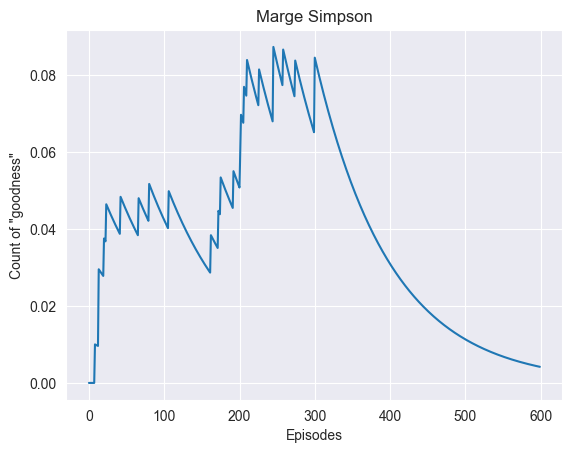

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [248]:
temp_count = catch_phrase_per_episode(0)
print(temp_count)

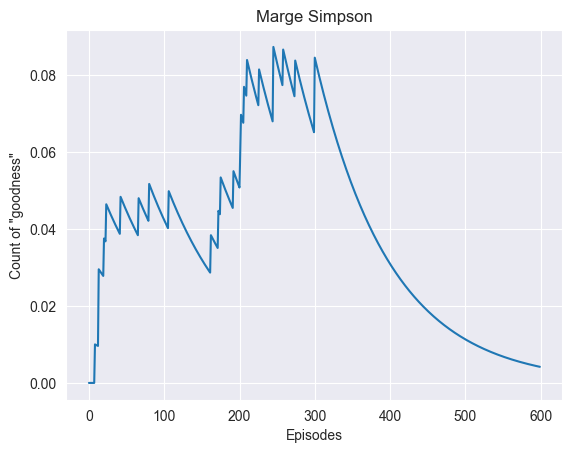

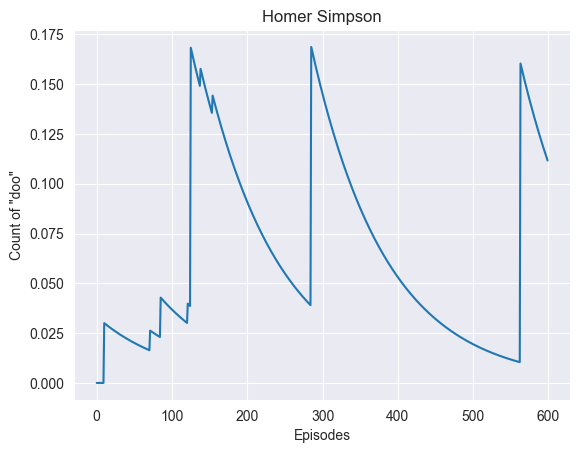

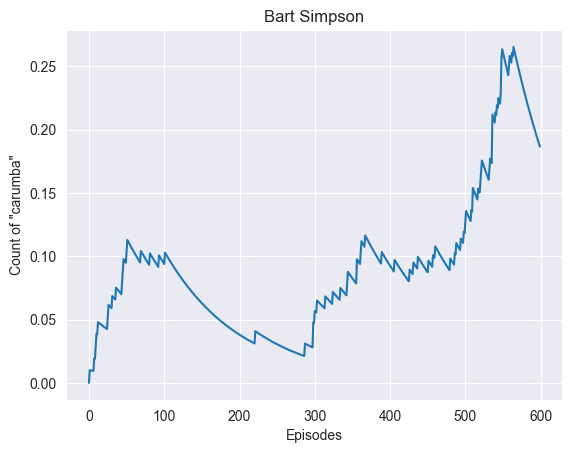

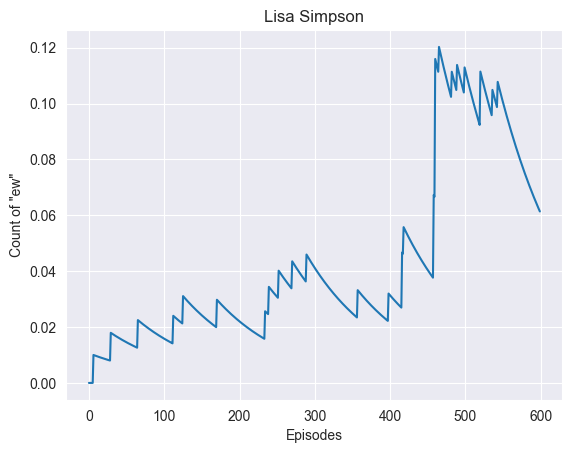

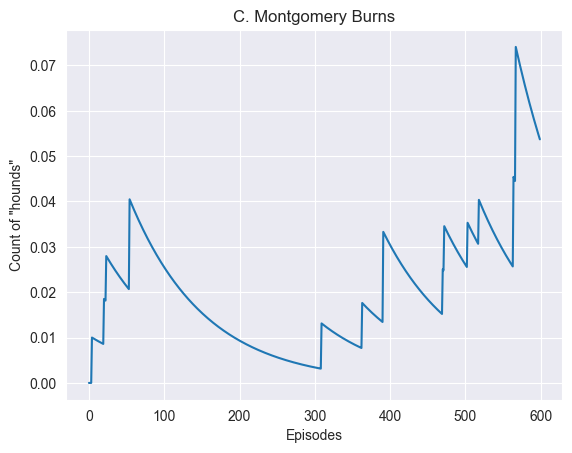

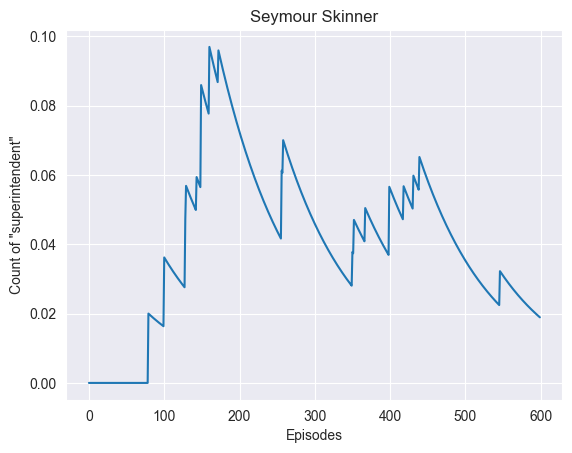

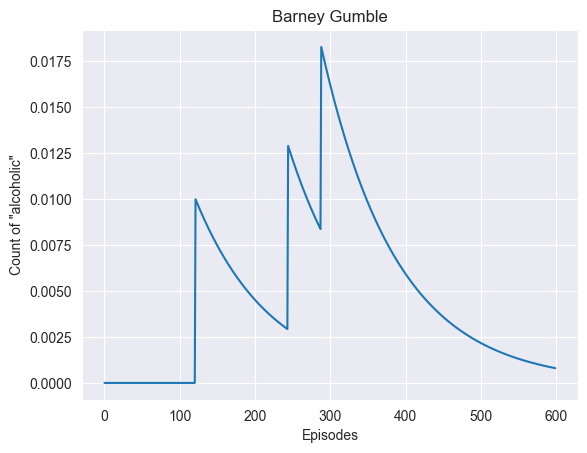

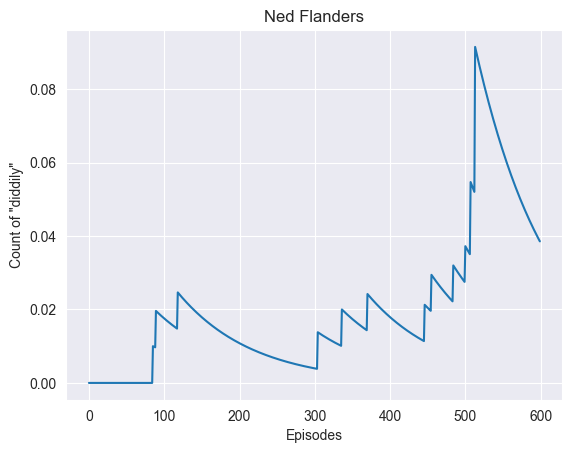

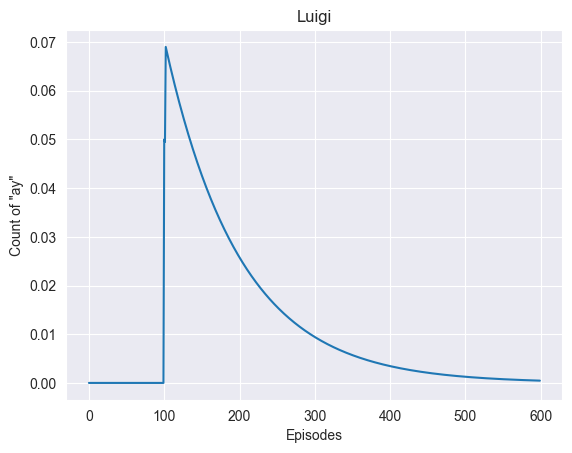

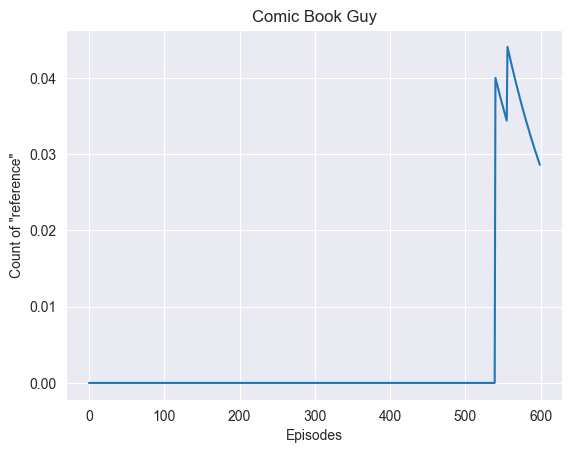

In [219]:
for i in range(len(selected_characters)):
    catch_phrase_per_episode(i)

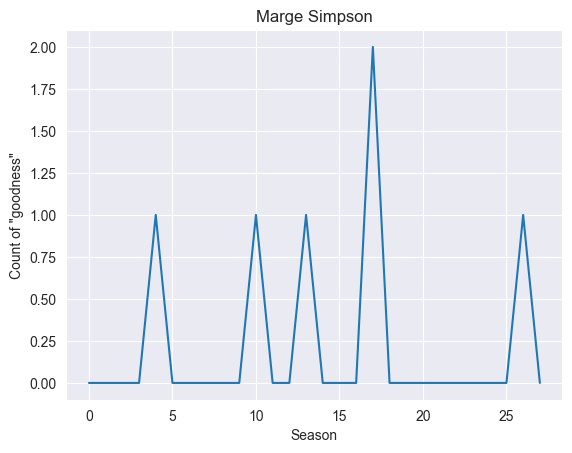

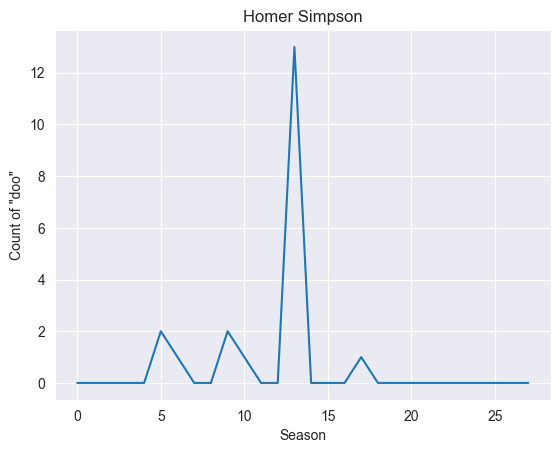

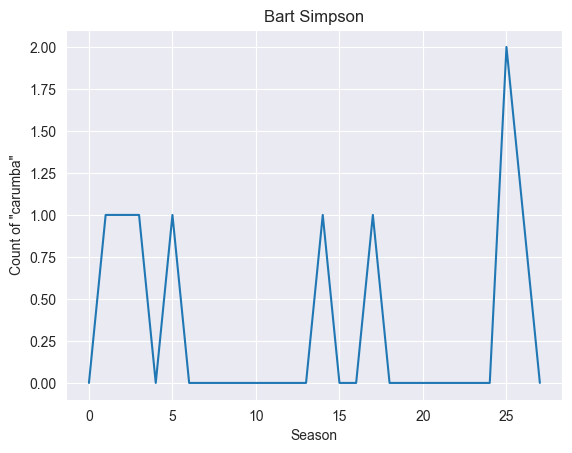

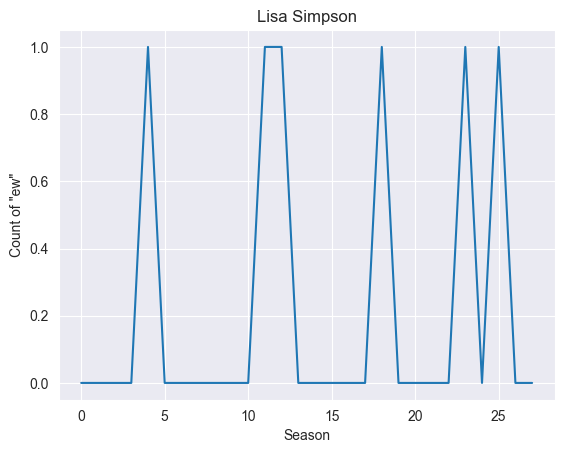

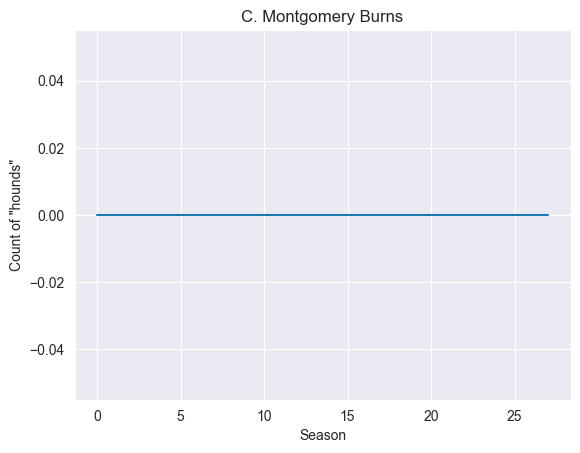

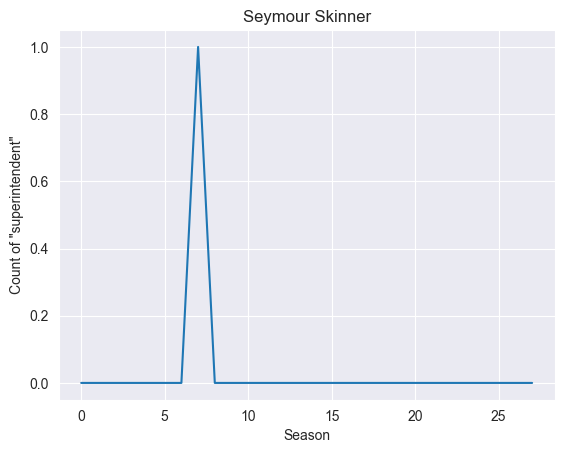

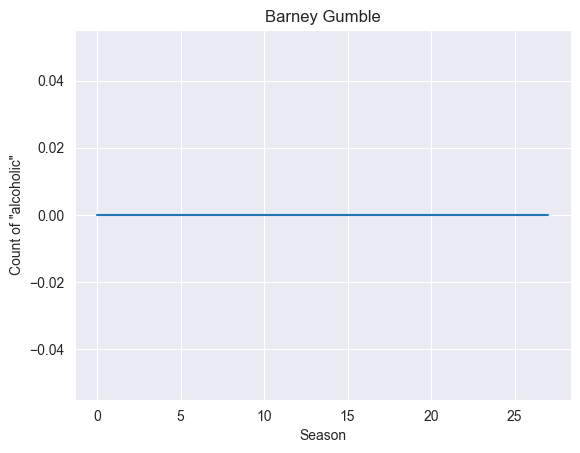

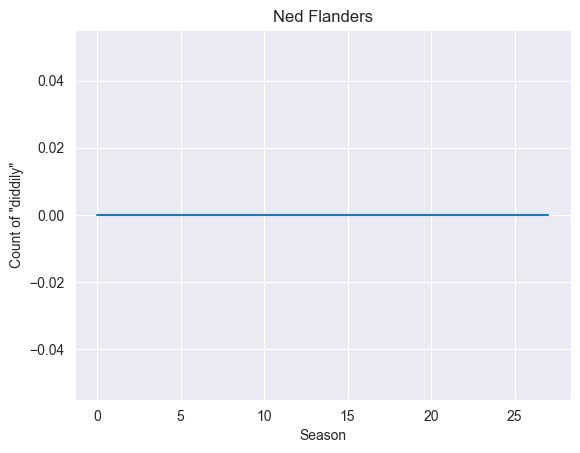

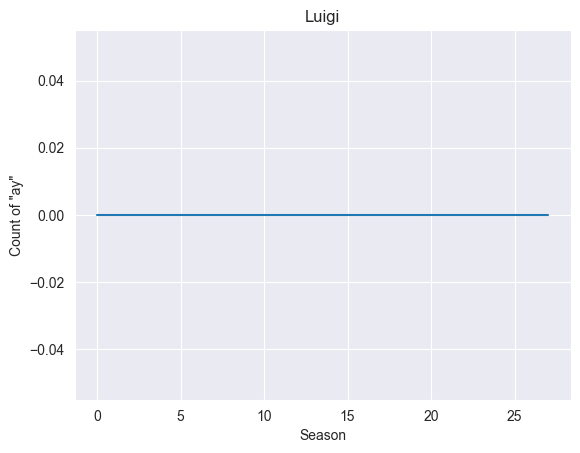

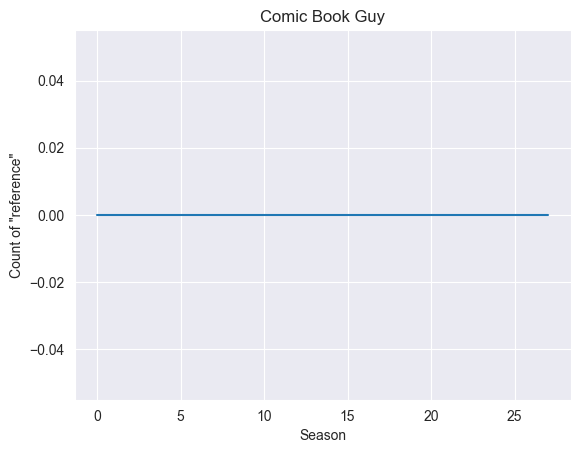

In [226]:
for i in range(len(selected_characters)):
    catch_phrase_per_season(i)